
# Diagnosing Heart Disease of Patient's from Cleveland based on Age, Resting Blood Pressure, Cholesterol, and Max Heart Rate.

## Group 30: Toby Lau, Neil Lin, Tanish Gupta, Kristy Fielding

### Background Information & Introduction

Heart disease is one of the leading causes of death across the United States of America that is caused by a wide variety of factors. Common heart diseases include coronary heart disease, arrhythmias, strokes, etc. Throughout the 21st century, medical professionals have deduced how certain factors may give leeway to one having a certain type of heart disease and the extent of its danger to the human body (Centers for Disease Control and Prevention, 2023). In this project, we will try to determine whether a patient has heart disease given the relevant predictors. The dataset being used is a collection of patients from Cleveland, Ohio, all of whom were suspected to have heart disease. The dataset contains 14 attributes that could contribute to a patient's heart disease. Of the 14, we hope to train a model that is able to classify these stages given some attributes.

**Research Question: How can age, resting blood pressure, cholesterol, and max heart rate diagnose heart disease in patients from Cleveland?**

## Methods
To obtain a high quality model trained on the data used, we will have to do some data preprocessing and model tuning.

### Data reading and wrangling
1. Import the required libraries and load the dataset from the web
2. Assign the correct column names and types to the dataset
3. Wrangle the dataset into a tidy format.
4. Split the data into training and testing sets
5. Summarize and visualize data

### Hyperparameter Tuning
1. Set a seed.
2. Create a recipe that defines the "stage" column as our response variable and "age", "restbps", "chol", and "thalach" columns as predictors.
3. Standardize predictors using step_scale and step_center on all predictors.
4. Create a $k$-nn model  with the neighbors = tune() parameter.
5. Create a tibble with a single neighbors column containing numbers from 1 to 100.
6. Perform Cross-validation on 10 folds to tune the model and find the best $k$ value.
7. Plot the accuracy of the model against the number of neighbors to determine the $k$ value with the highest accuracy.
8. Using the $k$ value that obtained the highest accuracy, create a new $k$-nn model

### Evaluating
1. Test the model using our testing data set.
2. Check for over/underfitting.
3. Create a confusion matrix
4. Assess the model's performance using tidymodels.


### Data reading and wrangling
First, we import the necessary libraries.

In [2]:
library(tidyverse)
library(ggplot2)
library(GGally)
library(tidymodels)
# install.packages("gridExtra")
# library(gridExtra)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“package ‘GGally’ was built under R version 4.3.2”
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowset

Then we read in our dataset from the web using read_csv.

In [3]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                          col_names = FALSE)
                          
head(cleveland_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


Table 1

The table above does not contain any column names. Fortunately, the data source contains a variable table that lists the specifications of each column. Using this table we can assign each column of Table 1 its correct name and type. The column names and order were taken from the data source. Using the mutate function, columns that are supposed to be integer are converted to integers with as.integer() and columns that are categorical are converted into factors with as.factor(). The source also mentions only the "ca" and "thal" columns contain missing values but those columns will not be used so they can be removed. Furthermore, only the "age", "chol", "trestbps", and "thalach" columns will be used to create the model so we can select only these columns. Finally, our data is clean.

In [4]:
colnames(cleveland_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
cleveland_data <- cleveland_data |> mutate(age = as.integer(age), sex = as.factor(sex), cp = as.factor(cp), trestbps = as.integer(trestbps), 
                                           chol = as.integer(chol), fbs = as.factor(fbs), restecg = as.factor(restecg),  thalach = as.integer(thalach),
                                           exang = as.factor(exang), oldpeak = as.integer(oldpeak), slope = as.factor(slope), ca = as.integer(ca), 
                                           thal = as.factor(thal), num = as.integer(num)) |> select(age, trestbps, chol, thalach, -ca, -thal, num)
head(cleveland_data)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `ca = as.integer(ca)`.
Caused by warning:
! NAs introduced by coercion”


age,trestbps,chol,thalach,num
<int>,<int>,<int>,<int>,<int>
63,145,233,150,0
67,160,286,108,2
67,120,229,129,1
37,130,250,187,0
41,130,204,172,0
56,120,236,178,0


Table 2 \
However, when we count the number of observations for each "num" category there is a severe imbalance in observations as seen in the plot below. Training a model on this data would result in a model with high recall but low precision (?) as there is not enough data from other categories to learn from.

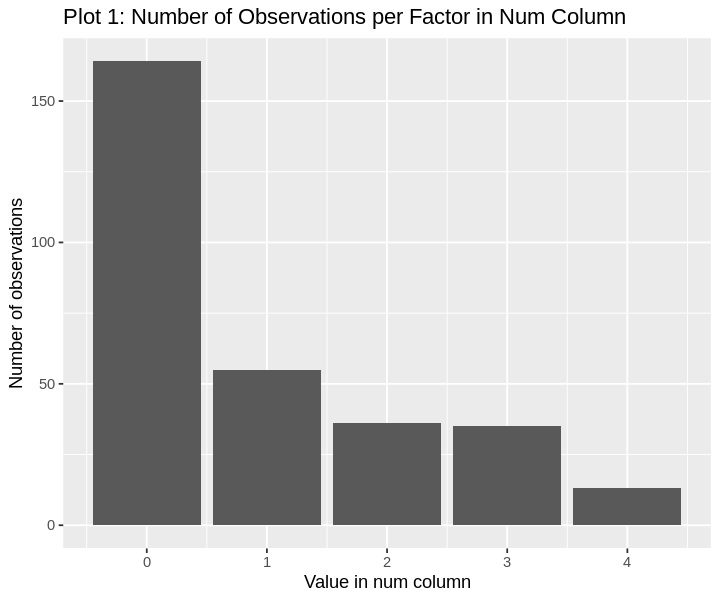

In [5]:
options(repr.plot.width = 6, repr.plot.height=5)
cleveland_summary <- cleveland_data |> group_by(num) |> summarize(count = n())
cleveland_summary_plot <- cleveland_summary |> ggplot(aes(num,count)) +
    geom_bar(stat = "identity") +
    labs(x = "Value in num column", y = "Number of observations") +
    ggtitle("Plot 1: Number of Observations per Factor in Num Column")
cleveland_summary_plot

According to the data source, values of 0 in the num column represent patients with <50% vessel diameter narrowing while values > 0 in the num column represent patients with >50% vessel diameter narrowing. Since mild heart disease is classified as <50% narrowing, moderate heart disease is classified as 50-80% narrowing, and severe heart disease is 80-100% narrowing (Cleveland Clinic). We can bucket the "num" values into respective "mild", "moderate", and "severe" classes into a new "stage" column. However, due to the class imbalance, we have decided to combine the "moderate" and "severe" classes. This corresponds to num values of 1-4. The following table represents how the new "stage" column relates to "num".

| Num value | Percentage blockage | Stage |
| -------- | ------- | ----|
| 0 | < 50% | Mild |
| 1-4 | > 50% | Moderate/Severe |

With only two classes, we will perform a binary classification instead.

age,trestbps,chol,thalach,num,stage
<int>,<int>,<int>,<int>,<int>,<fct>
63,145,233,150,0,Mild
67,160,286,108,2,Moderate/Severe
67,120,229,129,1,Moderate/Severe
37,130,250,187,0,Mild
41,130,204,172,0,Mild
56,120,236,178,0,Mild


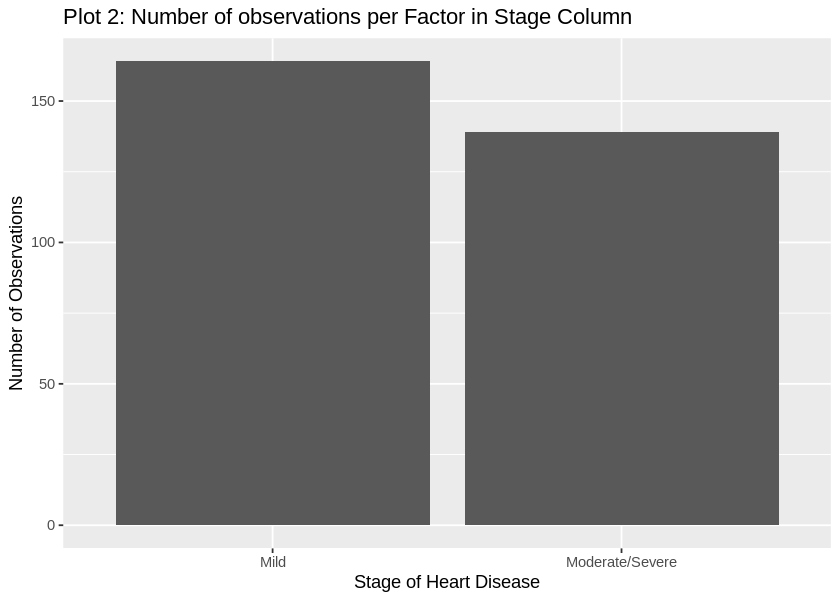

In [10]:
options(repr.plot.width = 7, repr.plot.height=5)

cleveland_staged <- cleveland_data |> 
    mutate(stage = cut(num, breaks=c(-Inf,0,4), labels=c("Mild","Moderate/Severe")))
head(cleveland_staged)
cleveland_staged_summary <- cleveland_staged |> group_by(stage) |> summarize(count = n()) |> ggplot(aes(stage,count)) +
    geom_bar(stat = "identity") +
    labs(x = "Stage of Heart Disease", y = "Number of Observations") +
    ggtitle("Plot 2: Number of observations per Factor in Stage Column")
cleveland_staged_summary

By combining the classes, we get a more balanced number of classes in the whole dataset so we can split our data into training and testing splits without worrying about imbalance.

In [11]:
set.seed(69)

split <- initial_split(cleveland_staged, prop=0.75, strata = stage)
data_training <- training(split)
data_testing <- testing(split)

nrow(data_training)
nrow(data_testing)


[1] 227

[1] 76

Splitting our data into training and testing datasets using initial_split will ensure that bias and order were removed. There are 227 rows (75%) in the training set and 76 rows (25%) in the testing set. With this respective proportion, we will have enough data to sufficiently train our model and then utilize the testing set to evaluate its performance on unseen data. 

In [136]:
training_summary <- data_training |> group_by(stage) |> summarize(count = n(), Prop = (n()/227)*100)
training_summary

stage,count,Prop
<fct>,<int>,<dbl>
Mild,123,54.18502
Moderate/Severe,104,45.81498


Table 5\
Within the training dataset we also have a roughly balanced amount of classes with 54% of the data being "Mild" and 46% of the data being "Moderate/Severe". This should sufficiently reduce the bias in our model. To make sure the two classes are distinguishable we tabulate some each class' properties below.

In [151]:
training_means <- data_training |> group_by(stage) |> summarize(mean_age = mean(age), mean_trestbps = mean(trestbps), mean_chol = mean(chol), mean_thalach = mean(thalach))
training_means

stage,mean_age,mean_trestbps,mean_chol,mean_thalach
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Mild,52.90244,129.2846,240.8130,157.8618
Moderate/Severe,56.88462,134.9231,253.5673,136.1058


Table 6\
According to the table above, there is quite a considerable difference in the mean of each predictor for each class. It shows that patients in the "Moderate/Severe" stage are older, have a higher resting heart rate, and higher levels of cholesterol but a lower max heart rate while the opposite is true for patients in the "Mild" stage.

### Summarizing and Visualizing the Data
With our training set, we can summarize and visualize our training data to uncover any underlying patterns in relation to our new "stage" column. The following code represents a ggpairs plot on our training data set that plots each predictor against each other. 

In [1]:
#Predictor 1 = age
#Predictor 2 = Resting Blood Pressure
#Predictor 3 = Cholesterol
#Predictor 4 = Max Heart Rate
options(options.repr.width = 10, options.repr.height = 10)

# predictor_1 <- data_training |>
#     ggplot(aes(x = age, fill = stage))+
#     geom_density() +
#     labs(x = "Age of Patient (years old)", y = "Density", title = "Plot 1a) Density Plot of the Age of Patients")+
#     theme(text = element_text(size = 10))

# predictor_2 <- data_training |>
#     ggplot(aes(x = trestbps, fill = stage))+
#     geom_density()+
#     labs(x = "Resting Blood Pressure (mmHg)", y = "Density", title = "Plot 1b) Density Plot of each Patient's Resting Blood Pressure ")+
#     theme(text = element_text(size = 10))

# predictor_3 <- data_training |>
#     ggplot(aes(x = chol, fill = stage))+
#     geom_density()+
#     labs(x = "Cholesterol (mg/dL)", y = "Density", title = "Plot 1c) Density plot of each Patient's Chloesterol Level")+
#     theme(text = element_text(size = 10))

# predictor_4 <- data_training |>
#     ggplot(aes(x = thalach, fill = stage))+
#     geom_density()+
#     labs(x = "Max Heart Rate (Beats per Minute)", y = "Density", title = "Plot d) Density plot of each Patient's Max Heart Rate") +
#     theme(text = element_text(size = 10))

# predictor_1
# predictor_2
# predictor_3
# predictor_4

ggpair <- ggpairs(data_training, columns = 1:4, ggplot2::aes(colour = stage,alpha = 0.5), title="Plot 3: GGPairs plot of predictors")
ggpair

# summary <- grid.arrange(predictor_1, predictor_2, predictor_3, predictor_4, nrow = 2)
# summary

ERROR: Error in ggpairs(data_training, columns = 1:4, ggplot2::aes(colour = stage, : could not find function "ggpairs"


We can see that for some predictors there are fairly distinct regions that distinguish between the two classes we are predicting. For example, patient's with mild heart disease tend to have a higher maximum heart rate and patient's who are older tend to have more cholesterol.

The ggpairs plot also contains density plots to see how each the density of each predictor changes with class. This tells us on average, that patient's with mild heart disease are younger and patient's with a lower maximum heart rate have moderate/severe heart disease.

**Predictor 1 (Age)**

As per the graph it is evident that with an increase in age, individuals with existing heart disease, face a more severe stage of condition. Therefore, we can infer a proportional relationship between age and severity of heart disease.

**Predictor 2 (Resting Blood Pressure)**

As per the graph it is evident that with an increase in resting blood pressure, individuals with existing heart disease, face a more severe stage of condition. Therefore, we can infer a proportional relationship between resting blood pressure and severity of heart disease.

**Predictor 3 (Cholesterol)**

???

**Predictor 4 (Max Heart Rate)**

As per the graph it is evident that with a decrease in max heart rate, individuals with existing heart disease, face a more severe stage of condition. Therefore, we can infer an inverse relationship between max heart rate and severity of heart disease.

- Not sure we need this

### Identifying the Ideal K Value

To identify the ideal K value, we create a model for each $k$ from 1 to 100 and select the $K$ value that obtained the highest accuracy.

In [104]:
set.seed(69)

k_vals <- tibble(neighbors = seq(1,100,1))

tune_recipe <- recipe(stage ~ age + chol + trestbps + thalach, data = data_training) |>
    step_scale(all_predictors()) |> 
    step_center(all_predictors()) 

tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

tune_cv <- vfold_cv(data_training, v = 10, strata = stage)

tune_wf <- workflow() |>
    add_recipe(tune_recipe) |>
    add_model(tune_spec)

tune_results <- tune_wf |>
    tune_grid(resamples = tune_cv, grid = k_vals) |>
    collect_metrics()

head(tune_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6123847,10,0.02218276,Preprocessor1_Model001
1,roc_auc,binary,0.6107343,10,0.02145355,Preprocessor1_Model001
2,accuracy,binary,0.6123847,10,0.02218276,Preprocessor1_Model002
2,roc_auc,binary,0.6172057,10,0.03476213,Preprocessor1_Model002
3,accuracy,binary,0.6430665,10,0.03000973,Preprocessor1_Model003
3,roc_auc,binary,0.6594260,10,0.03341496,Preprocessor1_Model003


Table 6

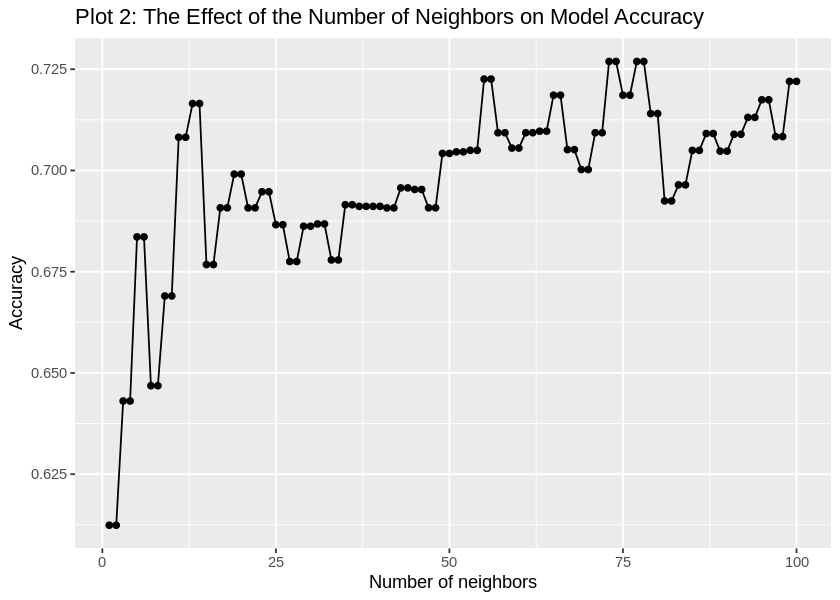

In [143]:
options(repr.plot.width=7, repr.plot.height=5)

k_vs_accuracy <- tune_results |> filter(.metric == "accuracy") |> ggplot(aes(neighbors, mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of neighbors", y = "Accuracy") +
    ggtitle("Plot 2: The Effect of the Number of Neighbors on Model Accuracy")
k_vs_accuracy

We can see that the accuracy of the model is the best when $k$ is roughly 73-74 or 76-77. We can narrow down the value we need by outputting the table and arranging the "mean" column in descending order.

In [144]:
ideal_k_table <- tune_results |> filter(.metric == "accuracy") |> arrange(desc(mean)) |> slice(1:5)
ideal_k_table

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
73,accuracy,binary,0.7269269,10,0.03460943,Preprocessor1_Model073
74,accuracy,binary,0.7269269,10,0.03460943,Preprocessor1_Model074
77,accuracy,binary,0.7269269,10,0.03325635,Preprocessor1_Model077
78,accuracy,binary,0.7269269,10,0.03325635,Preprocessor1_Model078
55,accuracy,binary,0.7225791,10,0.03278712,Preprocessor1_Model055


Table 7\
We can see from the table above that 73 neighbors obtained the best accuracy of approximately 73%, meaning our ideal $k$ is 73.

## Discussion

## References